In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as ns
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("../src")

from decentralized import *
from graphs import *
from models import *
from utils import *
from metrics import *
from consensus import *
from tqdm import tqdm, trange

import matplotlib 
matplotlib.rcParams['pdf.fonttype'] = 42

matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib.lines import Line2D
from PIL import Image, ImageOps
import seaborn as sns
sns.set_theme()

In [2]:
# Defining the attack parameters
setup = system_startup()
#G = test_graph()
G=nx.florentine_families_graph()
G = nx.convert_node_labels_to_integers(G)
G = nx.relabel_nodes(G, {0:1, 1:0})
N = G.number_of_nodes()
n_iter = 5
attackers = [0]
W = LaplacianGossipMatrix(G)
Wt = torch.tensor(W).float()
R = ReconstructOptim(G, n_iter, attackers)

CPUs: 1, GPUs: 0 on flille.


In [3]:
np.random.seed(0)
layout = nx.spring_layout(G)

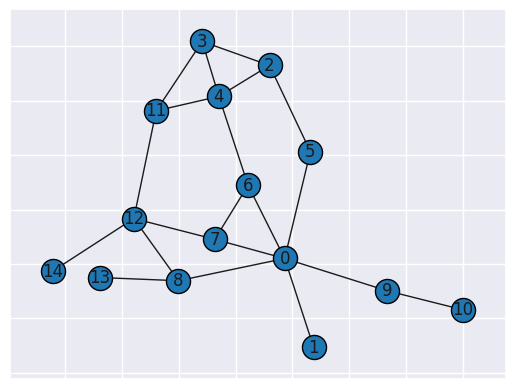

In [4]:
nx.draw_networkx(G, pos=layout, edgecolors = "black")

### A reconstruction example (figure 5, right)

In [7]:
# Defining the model
torch.manual_seed(0)
model = Model(FC_Model(3072, 10), invert_gradient_FC_Model, setup)
D = Decentralized(R, model, setup, targets_only = True, data_root = "../images")
lr = 1e-5
D.run(lr);
x_hat = R.reconstruct_LS_target_only(D.sent_params, D.attackers_params)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:06<00:00, 27976487.80it/s]


Extracting ../images/cifar10/cifar-10-python.tar.gz to ../images/cifar10
Data Ok


In [ ]:
outputs = []
for j in range(len(x_hat)):
    outputs.append(model.invert( x_hat[j], lr))

In [7]:
reconstructed = psnr(torch.cat(outputs),torch.cat(D.data)[1:] )> 10

<Figure size 640x480 with 0 Axes>

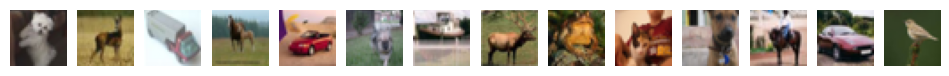

In [8]:
# Plotting the initial data
target_inputs = torch.cat(D.data)[1:] 
plot_tensors(target_inputs, title = 'inputs')

<Figure size 640x480 with 0 Axes>

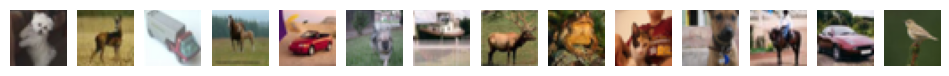

In [9]:
plot_tensors(torch.cat(outputs), title = 'outputs')

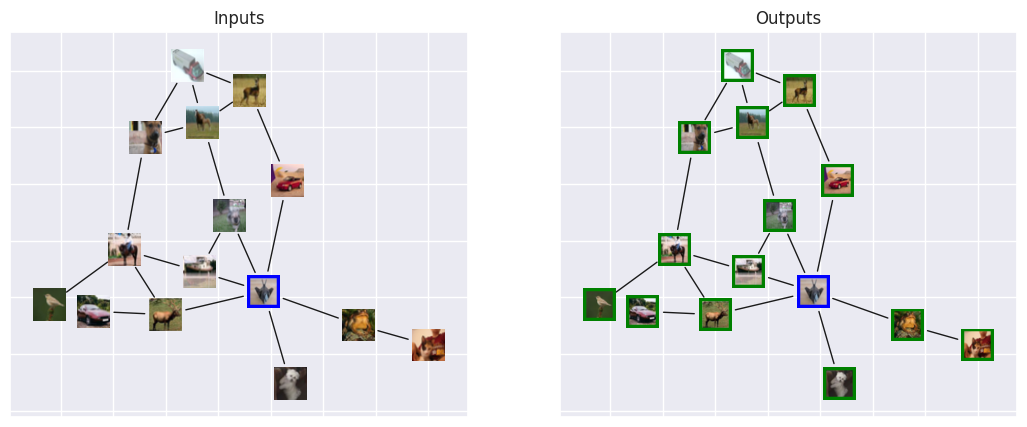

In [10]:
np.random.seed(0)
pos = nx.spring_layout(G)
fig, ax = plt.subplots(1,2, figsize = (13,5))
nx.draw_networkx_edges(
    G,
    pos=pos,
    ax=ax[0],
    arrows=True,
    arrowstyle="-",
    min_source_margin=15,
    min_target_margin=15,
)
tr_figure = ax[0].transData.transform
tr_axes = fig.transFigure.inverted().transform
icon_size = (ax[0].get_xlim()[1] - ax[0].get_xlim()[0]) * 0.030
icon_center = icon_size / 2.0
target_inputs = torch.cat(D.data) 
for n in range(N):
    xf, yf = tr_figure(pos[n])
    xa, ya = tr_axes((xf, yf))
    # get overlapped axes and plot icon
    a = plt.axes([xa - icon_center, ya - icon_center, icon_size, icon_size])
    #tensor_np = outputs[n-1].mul_(ds).add_(dm).clamp_(0, 1)
    tensor_np = torch.clone(target_inputs[n])
    tensor_np = tensor_np.mul_(ds).add_(dm).clamp_(0, 1)
    tensor_np = tensor_np.squeeze().numpy()  # Assuming you're using PyTorch
    
    # Step 2: Reshape the NumPy array to the appropriate shape for an image
    # Reshape to (3, 32, 32) from (1, 3, 32, 32)
    tensor_np = tensor_np.transpose((1, 2, 0))
    
    # Step 3: Convert the NumPy array to a PIL image
    pil_image = Image.fromarray((tensor_np * 255).astype(np.uint8))
    if n==0:
        pil_image = ImageOps.expand(pil_image, border=4, fill='blue')
    a.imshow(pil_image)
    a.axis("off")

ax[0].set_title("Inputs")

# OUTPUTS

np.random.seed(0)
pos = nx.spring_layout(G)

nx.draw_networkx_edges(
    G,
    pos=pos,
    ax=ax[1],
    arrows=True,
    arrowstyle="-",
    min_source_margin=15,
    min_target_margin=15,
)
tr_figure = ax[1].transData.transform
tr_axes = fig.transFigure.inverted().transform
icon_size = (ax[1].get_xlim()[1] - ax[1].get_xlim()[0]) * 0.030
icon_center = icon_size / 2.0
# Attacker data 
xf, yf = tr_figure(pos[0])
xa, ya = tr_axes((xf, yf))
# get overlapped axes and plot icon
a = plt.axes([xa - icon_center, ya - icon_center, icon_size, icon_size])
#tensor_np = outputs[n-1].mul_(ds).add_(dm).clamp_(0, 1)
tensor_np = torch.clone(target_inputs[0])
tensor_np = tensor_np.mul_(ds).add_(dm).clamp_(0, 1)
tensor_np = tensor_np.squeeze().numpy()  # Assuming you're using PyTorch

# Step 2: Reshape the NumPy array to the appropriate shape for an image
# Reshape to (3, 32, 32) from (1, 3, 32, 32)
tensor_np = tensor_np.transpose((1, 2, 0))

# Step 3: Convert the NumPy array to a PIL image
pil_image = Image.fromarray((tensor_np * 255).astype(np.uint8))
pil_image = ImageOps.expand(pil_image, border=4, fill='blue')
a.imshow(pil_image)
a.axis("off")
for n in range(N-1):
    xf, yf = tr_figure(pos[n+1])
    xa, ya = tr_axes((xf, yf))
    # get overlapped axes and plot iconL
    a = plt.axes([xa - icon_center, ya - icon_center, icon_size, icon_size])
    tensor_np = torch.clone(outputs[n])
    tensor_np = tensor_np.mul_(ds).add_(dm).clamp_(0, 1)
    #tensor_np = target_inputs[n].mul_(ds).add_(dm).clamp_(0, 1)
    tensor_np = tensor_np.squeeze().numpy()  # Assuming you're using PyTorch
    
    # Step 2: Reshape the NumPy array to the appropriate shape for an image
    # Reshape to (3, 32, 32) from (1, 3, 32, 32)
    tensor_np = tensor_np.transpose((1, 2, 0))
    
    # Step 3: Convert the NumPy array to a PIL image
    pil_image = Image.fromarray((tensor_np * 255).astype(np.uint8))
    if reconstructed[n]:
        pil_image = ImageOps.expand(pil_image, border=4, fill='green')
    else:
        pil_image = ImageOps.expand(pil_image, border=4, fill='red')
    a.imshow(pil_image)
    a.axis("off")
ax[1].set_title("Outputs")
#plt.savefig("../experiments/gd/florentine/inputs_outputs_on_graph.pdf")

extent = ax[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#plt.savefig("../experiments/gd/florentine/inputs_outputs_on_graph_0.pdf", bbox_inches=extent)
extent = ax[1].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
#plt.savefig("../experiments/gd/florentine/inputs_outputs_on_graph_1.pdf", bbox_inches=extent)

plt.show()



### Effect of learning rate (figure 11)

In [11]:
# Defining the model
torch.manual_seed(0)
model = Model(FC_Model(3072, 10), invert_gradient_FC_Model, setup)

In [12]:
psnrs_list = []
sqs_list = []
rss_list = []
success_rates = []
lr_list = np.array([1e-6, 1e-5, 5e-5, 0.0001, 0.0005, 0.001, 0.005])

n_exp = 4
np.random.seed(42)
seeds = np.random.randint(0, 10000, n_exp)

for lr in lr_list:
    psnrs = []
    sqs = []
    rss = []
    for seed in seeds:
        D = Decentralized(R, model, setup, seed = seed, targets_only=True);
        target_inputs = torch.cat(D.data)[1:] 
        #D.pretrain(60, 0.01);
        grs = D.run(lr);
        # Reconstructing the gradients from the received parameters
        x_hat = R.reconstruct_LS_target_only(D.sent_params, D.attackers_params)
        # Inverting the gradients to get the initial data
        outputs = []
        for j in range(N-1):
            outputs.append(model.invert( x_hat[j], lr))
        psnr_score, sq_score, relative_score = compute_metrics(torch.cat(outputs),target_inputs)
        psnrs.append(psnr_score)
        sqs.append(sq_score)
        rss.append(relative_score)
    psnrs = torch.stack(psnrs)
    psnrs_list.append(psnrs)
    sqs_list.append( torch.tensor(sqs))
    rss_list.append( torch.tensor(rss))

Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verif

In [13]:
psnrs_mean = torch.stack(psnrs_list).mean(1)
psnrs_var = torch.stack(psnrs_list).var(1)
sqs_mean = torch.stack(sqs_list).mean(1)
sqs_var = torch.stack(sqs_list).var(1)
rss_mean = torch.stack(rss_list).mean(1)
rss_var = torch.stack(rss_list).var(1)

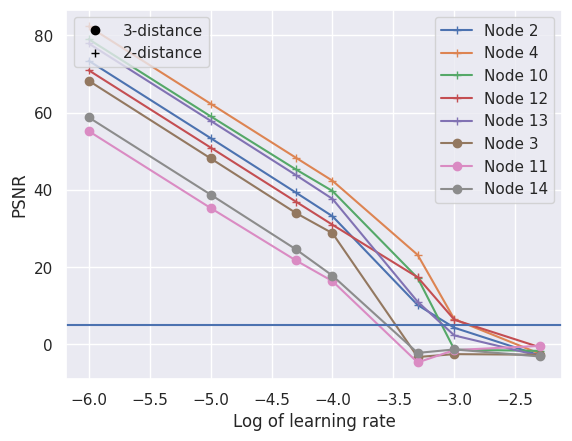

In [14]:
nodes_2 = [1,3, 9, 11, 12]
nodes_3 = [2,10,13]
for node in nodes_2:
    plt.plot(np.log10(lr_list),[psnrs_mean[i][node] for i in range(len(psnrs_mean))] , "+-", label =f"Node {node+1}")
for node in nodes_3:
    plt.plot(np.log10(lr_list),[psnrs_mean[i][node] for i in range(len(psnrs_mean))] , "o-",label =f"Node {node+1}")

symbol1 = Line2D([0], [0], marker='o', color='black', linewidth=0) 
symbol2 = Line2D([0], [0], marker='+', color='black', linewidth=0) 
legend1 = plt.legend([symbol1 ,  symbol2 ], ["3-distance","2-distance"],loc=2)
plt.legend(loc=1)
plt.gca().add_artist(legend1)
plt.xlabel("Log of learning rate")
plt.ylabel("PSNR") 
plt.axhline(5)
plt.show()
#plt.savefig("../experiments/gd/florentine/distance_n_exp_4" + "/psnr_stacked_final.pdf", bbox_inches='tight', dpi=300)

### Varying the attacker position (figure 5, left)

In [15]:
G = nx.florentine_families_graph()
G = nx.convert_node_labels_to_integers(G)
N = G.number_of_nodes()
n_iter = 7
lr = 1e-5
attackers = [0]
psnrs = []
sqs = []
rss = []

n_exp = 10
seed = 0
seeds = np.random.randint(0, 10000, n_exp)
psnrs_list = np.zeros((N, n_exp, N-1))
for i in range(N):
    # Defining the model
    torch.manual_seed(0)
    model = Model(FC_Model(3072, 10), invert_gradient_FC_Model, setup)
    G = nx.florentine_families_graph()
    G = nx.convert_node_labels_to_integers(G)
    G = nx.relabel_nodes(G, {0:i, i:0})
    R = ReconstructOptim(G, n_iter, attackers)
    for k, seed in enumerate(seeds):
        D = Decentralized(R, model, setup, seed=seed, targets_only = True)
        D.run(lr);
        x_hat = R.reconstruct_LS_target_only(D.sent_params, D.attackers_params)
        outputs = []
        for j in range(N-1):
            outputs.append(model.invert( x_hat[j], lr))
        target_inputs = torch.cat(D.data)[1:] 
        psnr_score, sq_score, relative_score =  compute_metrics(torch.cat(outputs),target_inputs)
        psnrs_list[i, k] = psnr_score
    psnrs.append(psnr_score)
    sqs.append(sq_score)
    rss.append(relative_score)

Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verified
Data Ok
Files already downloaded and verif

In [16]:
psnr_avg = psnrs_list.mean(1)
success_rates = ((psnr_avg>=10).sum(1)/14)


In [17]:
sns.reset_orig()

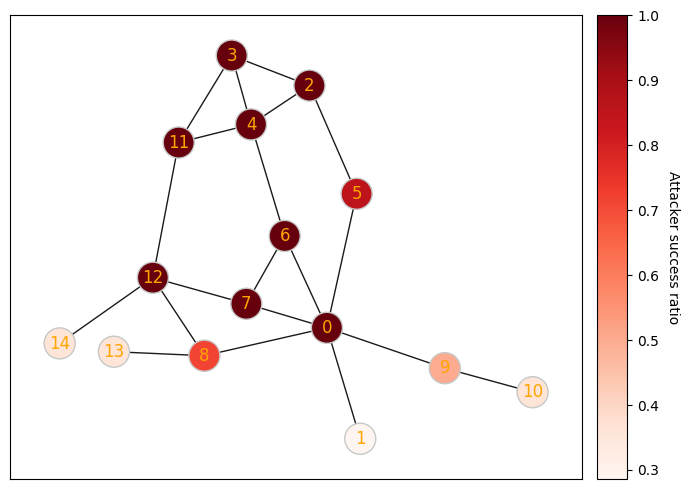

In [18]:
G = nx.florentine_families_graph()
G = nx.convert_node_labels_to_integers(G)
G = nx.relabel_nodes(G, {0:1, 1:0})
fig = plt.figure(figsize=(7, 5), frameon=False)
gs = matplotlib.gridspec.GridSpec(1, 2, width_ratios=[0.95, 0.05])
#Main plot
ax_main = plt.subplot(gs[0])
# labels ={i:np.around(success_rates[i].item(), 2) for i in G.nodes()} 
np.random.seed(0)
layout = nx.spring_layout(G)
nx.draw_networkx(G,  pos = layout, edgecolors = "xkcd:silver", with_labels=True , 
                 font_color = 'orange', node_size = 500, font_size = 12 , node_color = success_rates , cmap = "Reds")
#plt.box(False)
colors = success_rates
cmap=plt.cm.Reds
vmin = min(colors)
vmax = max(colors)

# Add a color bar
ax_cbar = plt.subplot(gs[1])
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=min(success_rates), vmax=max(success_rates)))
sm._A = []  # Empty array for the data range
cbar = plt.colorbar(sm, cax=ax_cbar)
cbar.set_label('Attacker success ratio', rotation=270, labelpad=15) 
# Adjust layout to prevent clipping of colorbar
plt.tight_layout()





#plt.savefig("../experiments/gd/florentine/rand_position_success/heatmatp_figure_new_with_border.pdf")

# Display the plot
plt.show()